In [232]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [233]:
class Model(nn.Module):
    
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__(*args, **kwargs)
        
        self.fc1 = nn.Linear(10, 10)

In [234]:
class IPS(optim.Optimizer):
    def __init__(self, model_params, T, lower_bound):
        
        defaults = dict(T=T, lower_bound=lower_bound)
        
        super(IPS, self).__init__(model_params, defaults)
        
        self.best_loss = float('inf')
        self.best_params = None
        self.step_count = 0
        
        
    @torch.no_grad()
    def step(self, closure=None):
        
        self.step_count += 1
        if closure is not None:
            with torch.enable_grad():
                rtloss = closure()
                loss = rtloss.item()
                
        for group in self.param_groups:
            T = group['T']
            l_star = group['lower_bound']
            
            # boost convergence during initial stages
            current_t = min(self.step_count, T)
            
            for param in group['params']:
                if param.grad is None:
                    continue
                
                grad = param.grad.data
                grad_norm_sq = torch.sum(grad ** 2) + 1e-8
                
                inexact_step_size = (loss - l_star) / (grad_norm_sq * ((current_t) ** 0.5))
                
                # important, since we're using incremental stepsize without clamping gradient explodes
                # especially true in earlier steps
                inexact_step_size = torch.clamp(inexact_step_size, min=0.0, max=1.0)
                param.data.add_(grad, alpha=-inexact_step_size)
                
        if loss < self.best_loss:
            self.best_loss = loss
            self.best_params = [p.clone().detach() for p in self.param_groups[0]['params']]
                
        return rtloss
    
    def load_best_params(self):
        if self.best_params:
            for param, best_param in zip(self.param_groups[0]['params'], self.best_params):
                param.data.copy_(best_param)
                

In [235]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        
        self.losses = []
        

    def forward(self, x):
        x = x.view(-1, 28*28).float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [236]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(trainset), shuffle=True)

In [237]:
def train(model, optimizer):
    print(optimizer)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer

    num_epochs = 2
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss

            loss = optimizer.step(closure)

            if i % 100 == 0:
                print(f'Epoch {epoch+1}, Step {i}, Loss: {loss}')
            model.losses.append(loss.item())

    print("Training complete.")
    return model

In [238]:
def test(model):
    for i, (inputs, labels) in enumerate(testloader):
        output = model(inputs)
        output = output.argmax(axis=1)
        print(accuracy_score(labels, output.detach().numpy()))

In [239]:
ipsModel = SimpleNN().to(device)
ipsOptimizer = IPS(ipsModel.parameters(), T=2 * int(len(trainset) / 64), lower_bound=0)
train(ipsModel, ipsOptimizer)

IPS (
Parameter Group 0
    T: 1874
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.3125908374786377
Epoch 1, Step 100, Loss: 0.9273661375045776
Epoch 1, Step 200, Loss: 0.6990384459495544
Epoch 1, Step 300, Loss: 0.7355589866638184
Epoch 1, Step 400, Loss: 0.3885970115661621
Epoch 1, Step 500, Loss: 0.31068018078804016
Epoch 1, Step 600, Loss: 0.40995365381240845
Epoch 1, Step 700, Loss: 0.5203034281730652
Epoch 1, Step 800, Loss: 0.29886743426322937
Epoch 1, Step 900, Loss: 0.5494338274002075
Epoch 2, Step 0, Loss: 0.5223824977874756
Epoch 2, Step 100, Loss: 0.24104098975658417
Epoch 2, Step 200, Loss: 0.539198637008667
Epoch 2, Step 300, Loss: 0.3822484314441681
Epoch 2, Step 400, Loss: 0.3316398561000824
Epoch 2, Step 500, Loss: 0.29754602909088135
Epoch 2, Step 600, Loss: 0.3079441487789154
Epoch 2, Step 700, Loss: 0.3444878160953522
Epoch 2, Step 800, Loss: 0.30432745814323425
Epoch 2, Step 900, Loss: 0.7023770809173584
Training complete.


SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [240]:
adamModel = SimpleNN().to(device)
train(adamModel, torch.optim.Adam(adamModel.parameters(), lr=1e-3))


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch 1, Step 0, Loss: 2.312025308609009
Epoch 1, Step 100, Loss: 0.6043513417243958
Epoch 1, Step 200, Loss: 0.29267892241477966
Epoch 1, Step 300, Loss: 0.32983481884002686
Epoch 1, Step 400, Loss: 0.4587390124797821
Epoch 1, Step 500, Loss: 0.16946738958358765
Epoch 1, Step 600, Loss: 0.1428559422492981
Epoch 1, Step 700, Loss: 0.1576930582523346
Epoch 1, Step 800, Loss: 0.14136163890361786
Epoch 1, Step 900, Loss: 0.15378107130527496
Epoch 2, Step 0, Loss: 0.2518506348133087
Epoch 2, Step 100, Loss: 0.07651076465845108
Epoch 2, Step 200, Loss: 0.13633251190185547
Epoch 2, Step 300, Loss: 0.1918778419494629
Epoch 2, Step 400, Loss: 0.10386673361063004
Epoch 2, Step 500, Loss: 0.2164669930934906
Epoch 2, Step 600, Loss: 0.25764113664627075
Epoch 2, Step 700, Loss: 0.

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [241]:
test(adamModel)
test(ipsModel)

0.9466
0.9081


[2.312025308609009, 2.306102991104126, 2.294603109359741, 2.277878761291504, 2.2671587467193604, 2.27626633644104, 2.2598469257354736, 2.2315220832824707, 2.2520270347595215, 2.215817928314209, 2.213230848312378, 2.1929714679718018, 2.2005066871643066, 2.1136634349823, 2.1299707889556885, 2.106074094772339, 2.090616464614868, 2.076200485229492, 2.076500654220581, 1.992793321609497, 2.0130672454833984, 1.9185713529586792, 1.9656634330749512, 1.9323910474777222, 1.8385250568389893, 1.816983938217163, 1.7668070793151855, 1.7253679037094116, 1.7123438119888306, 1.777219295501709, 1.6560014486312866, 1.6733343601226807, 1.6091541051864624, 1.634235143661499, 1.6225515604019165, 1.6211520433425903, 1.5097020864486694, 1.492985725402832, 1.4213694334030151, 1.3938748836517334, 1.4417250156402588, 1.3311208486557007, 1.4157240390777588, 1.3580211400985718, 1.4376494884490967, 1.2041326761245728, 1.2111740112304688, 1.2328389883041382, 1.162408471107483, 1.0484627485275269, 1.226730465888977, 1

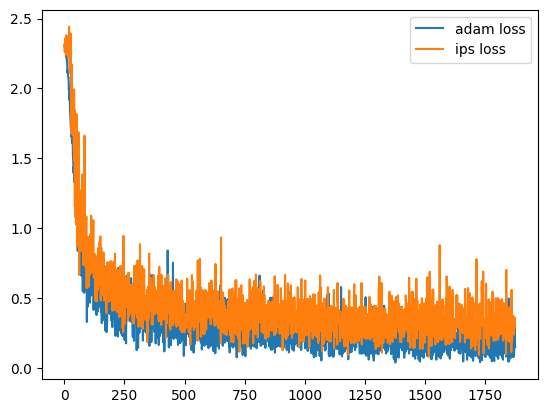

In [ ]:
plt.plot(adamModel.losses, label='adam loss')
plt.plot(ipsModel.losses, label='ips loss')
plt.legend()
plt.show()